In [83]:
%load_ext autoreload
%autoreload 2
%cd '../HOTS'
%matplotlib inline

import pickle
import numpy as np
import matplotlib.pyplot as plt

records_path = '../Records/'
dataset = 'nmnist'
timestr = '2021-02-08'
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_homeo_homeotest_histo.pkl'
nb_digit = 100
with open(f_name, 'rb') as file:
    score_THH, tim_jit, score_SHH, spa_jit = pickle.load(file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/antoine/homhots/HOTS/HOTS


In [84]:
tim_jit, spa_jit = np.sqrt(tim_jit), np.sqrt(spa_jit)

In [85]:
np.sqrt(16000)

126.49110640673517

In [86]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="mean")

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2, jitter0=120, log_wt=torch.log(10*torch.ones(1)), n_classes=10):
        super(LogisticRegressionModel, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(model,
    theta,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = model()
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]).to(device), torch.Tensor(y[:, None]).to(device)
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

In [87]:
logistic_model, loss = fit_data(LogisticRegressionModel, np.array(tim_jit), np.array(score_THH), verbose=True)

Iteration: 0 - Loss: 0.00977
Iteration: 16 - Loss: 0.00972
Iteration: 32 - Loss: 0.00968
Iteration: 48 - Loss: 0.00964
Iteration: 64 - Loss: 0.00961
Iteration: 80 - Loss: 0.00958
Iteration: 96 - Loss: 0.00955
Iteration: 112 - Loss: 0.00953
Iteration: 128 - Loss: 0.00951
Iteration: 144 - Loss: 0.00950
Iteration: 160 - Loss: 0.00950
Iteration: 176 - Loss: 0.00949
Iteration: 192 - Loss: 0.00949
Iteration: 208 - Loss: 0.00949
Iteration: 224 - Loss: 0.00949
Iteration: 240 - Loss: 0.00949
Iteration: 256 - Loss: 0.00949
Iteration: 272 - Loss: 0.00949
Iteration: 288 - Loss: 0.00949
Iteration: 304 - Loss: 0.00949
Iteration: 320 - Loss: 0.00949
Iteration: 336 - Loss: 0.00949
Iteration: 352 - Loss: 0.00948
Iteration: 368 - Loss: 0.00948
Iteration: 384 - Loss: 0.00948
Iteration: 400 - Loss: 0.00948
Iteration: 416 - Loss: 0.00948
Iteration: 432 - Loss: 0.00948
Iteration: 448 - Loss: 0.00948
Iteration: 464 - Loss: 0.00948
Iteration: 480 - Loss: 0.00948
Iteration: 496 - Loss: 0.00948
Iteration: 512 -

In [88]:
#print(jitter.shape, y.shape)
print(torch.exp(logistic_model.log_wt).item(), torch.exp(logistic_model.jitter0).item(), torch.exp(logistic_model.logit0).item())

20.506758227442372 6.762006295001826e+52 0.09911710841891205


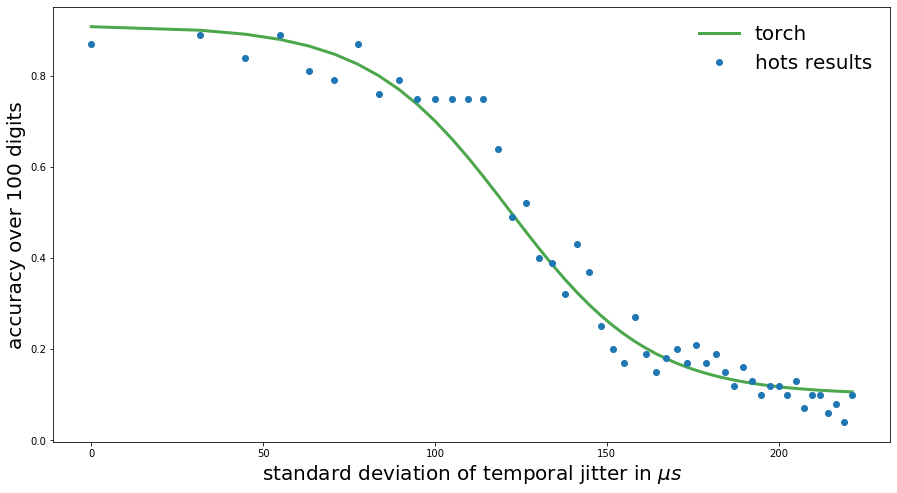

In [91]:
fig, ax = plt.subplots(figsize=(15, 8))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = np.array(tim_jit)
x_values = torch.Tensor(x[:, None]).to(device)
y_values = torch.squeeze(logistic_model(x_values)).cpu()
x_values = x_values.cpu()
ax.plot(x_values, y_values.detach().numpy(), "g", alpha=0.7, lw=3, label="LR fit")
ax.plot(tim_jit,score_THH, 'o', label='hots results')
#ax.plot(tim_jit,pred[:,0])
ax.set_xlabel(r"standard deviation of temporal jitter in $\mu s$", fontsize=20)
ax.set_ylabel(f"accuracy over {nb_digit} digits", fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

In [98]:
class LogisticRegressionModel_spatial(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2, jitter0=1, log_wt=torch.log(2*torch.ones(1)), n_classes=10):
        super(LogisticRegressionModel_spatial, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.jitter0 = torch.nn.Parameter(jitter0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))
        self.n_classes = n_classes

    def forward(self, jitter):
        p0 = torch.sigmoid(self.logit0)
        p = torch.sigmoid((self.jitter0-jitter)/torch.exp(self.log_wt))
        out = 1/self.n_classes + (1 - p0 - 1/self.n_classes) * p
        #out = 1-p0 / 2 + (1 - p0) * torch.sigmoid((jitter-self.jitter0 )/torch.exp(self.log_wt))
        return out

In [99]:
logistic_model, loss = fit_data(LogisticRegressionModel_spatial, np.array(spa_jit), np.array(score_SHH), verbose=True)

Iteration: 0 - Loss: 0.01374
Iteration: 16 - Loss: 0.01363
Iteration: 32 - Loss: 0.01353
Iteration: 48 - Loss: 0.01342
Iteration: 64 - Loss: 0.01332
Iteration: 80 - Loss: 0.01322
Iteration: 96 - Loss: 0.01312
Iteration: 112 - Loss: 0.01302
Iteration: 128 - Loss: 0.01294
Iteration: 144 - Loss: 0.01287
Iteration: 160 - Loss: 0.01281
Iteration: 176 - Loss: 0.01276
Iteration: 192 - Loss: 0.01272
Iteration: 208 - Loss: 0.01269
Iteration: 224 - Loss: 0.01267
Iteration: 240 - Loss: 0.01266
Iteration: 256 - Loss: 0.01265
Iteration: 272 - Loss: 0.01264
Iteration: 288 - Loss: 0.01264
Iteration: 304 - Loss: 0.01263
Iteration: 320 - Loss: 0.01263
Iteration: 336 - Loss: 0.01263
Iteration: 352 - Loss: 0.01263
Iteration: 368 - Loss: 0.01263
Iteration: 384 - Loss: 0.01263
Iteration: 400 - Loss: 0.01262
Iteration: 416 - Loss: 0.01262
Iteration: 432 - Loss: 0.01262
Iteration: 448 - Loss: 0.01262
Iteration: 464 - Loss: 0.01262
Iteration: 480 - Loss: 0.01262
Iteration: 496 - Loss: 0.01262
Iteration: 512 -

In [100]:
#print(jitter.shape, y.shape)
print(torch.exp(logistic_model.log_wt).item(), torch.exp(logistic_model.jitter0).item(), torch.exp(logistic_model.logit0).item())

0.6112069387226814 6.965579800074298 0.0932017061903872


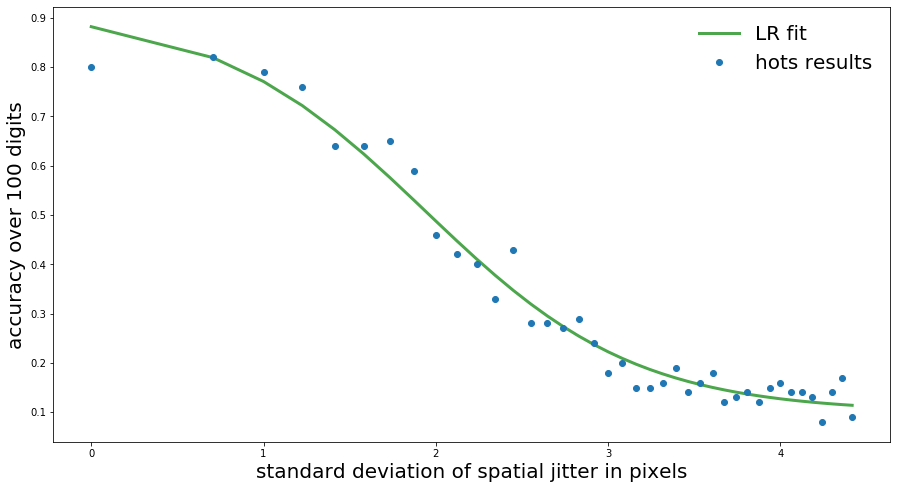

In [101]:
fig, ax = plt.subplots(figsize=(15, 8))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = np.array(spa_jit)
x_values = torch.Tensor(x[:, None]).to(device)
y_values = torch.squeeze(logistic_model(x_values)).cpu()
x_values = x_values.cpu()
ax.plot(x_values, y_values.detach().numpy(), "g", alpha=0.7, lw=3, label="LR fit")
ax.plot(x_values,score_SHH, 'o', label='hots results')
ax.set_xlabel("standard deviation of spatial jitter in pixels", fontsize=20)
ax.set_ylabel(f"accuracy over {nb_digit} digits", fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);